In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
DATASET_DIR = r"D:\Deep Learning\e-waste classification\train"
SEED = 23

In [6]:


# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    seed=SEED,
    shuffle=True,  # Shuffle the images to randomize the order
    image_size=(IMAGE_SIZE, IMAGE_SIZE),  # Ensure this is passed as a tuple (height, width)
    batch_size=BATCH_SIZE
)

# Check the dataset
for image_batch, label_batch in dataset.take(1):  # Take a single batch to inspect
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)
    print("Class labels in this batch:", label_batch.numpy())


Found 2400 files belonging to 10 classes.
Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)
Class labels in this batch: [5 8 4 3 7 8 7 9 7 1 7 7 0 9 7 1 2 8 4 2 3 4 7 8 1 9 8 8 7 0 2 3]


Class names: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


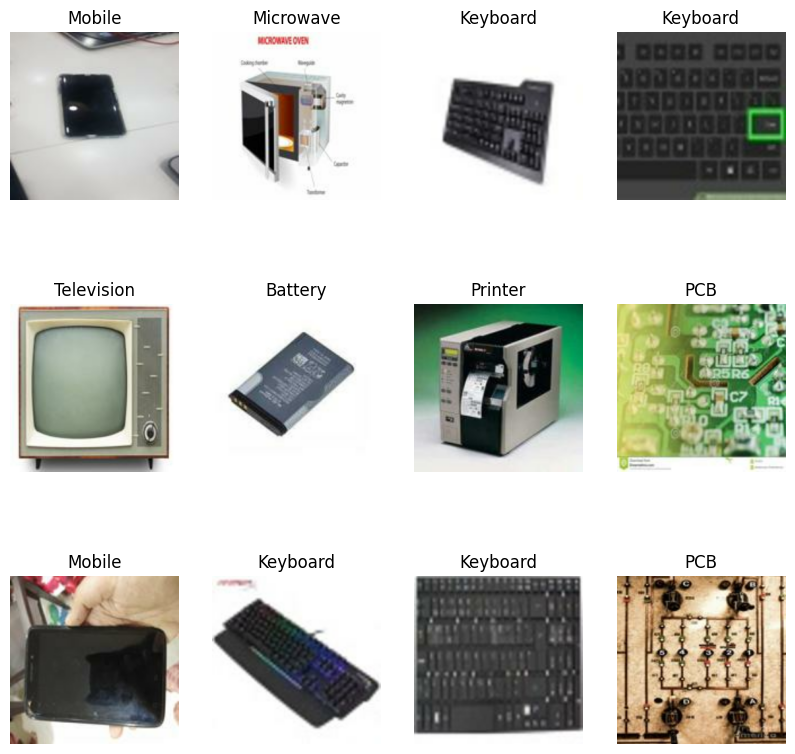

In [8]:

# Get class names
class_names = dataset.class_names
print("Class names:", class_names)

# Visualize the images and their labels
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):  # Take one batch from the dataset
    for i in range(12):  # Display the first 12 images in the batch
        ax = plt.subplot(3, 4, i + 1)  # Create a subplot (3 rows, 4 columns)
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # Convert image to uint8 for display
        plt.title(class_names[labels_batch[i]])  # Use class names for titles
        plt.axis("off")  # Turn off the axis for a cleaner plot
plt.show()


In [11]:
# Load training and validation datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,  # 80% training, 20% split into validation/test
    subset="training",
    seed=SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,  # 80% training, 20% split into validation/test
    subset="validation",
    seed=SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Split validation dataset further into validation and test datasets (50% each)
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 2)
val_dataset = val_dataset.skip(val_batches // 2)

# Print out the dataset structure to verify
print(f"Training batches: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_dataset)}")
print(f"Test batches: {tf.data.experimental.cardinality(test_dataset)}")


Found 2400 files belonging to 10 classes.
Using 1920 files for training.
Found 2400 files belonging to 10 classes.
Using 480 files for validation.
Training batches: 60
Validation batches: 8
Test batches: 7


In [12]:


data_augmentation = tf.keras.Sequential([
    # Rescale the pixel values from [0, 255] to [0, 1]
    tf.keras.layers.Rescaling(1./255),

    # Randomly flip the images horizontally and vertically
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),

    # Apply random rotation within a range of ±20% of a full rotation
    tf.keras.layers.RandomRotation(0.2),

    # Apply random zoom to the images
    tf.keras.layers.RandomZoom(0.2),

    # Randomly change the contrast of the image
    tf.keras.layers.RandomContrast(factor=0.2)
])


In [13]:

# Apply data augmentation to the training dataset
def preprocess_and_augment(image, label):
    image = data_augmentation(image, training=True)  # Ensure augmentation is applied
    return image, label

train_dataset = train_dataset.map(preprocess_and_augment)

# Print dataset structure to verify
print(f"Training batches: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_dataset).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test_dataset).numpy()}")

Training batches: 60
Validation batches: 8
Test batches: 7


In [25]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1

    ds_size = len(list(ds))  # Ensure ds_size is computed correctly

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [26]:
model = tf.keras.Sequential([
    # padding same is adding row and cols
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
# optimizer and loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()


model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 843ms/step - accuracy: 0.0967 - loss: 7.9208 - val_accuracy: 0.1384 - val_loss: 2.3114
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 857ms/step - accuracy: 0.1042 - loss: 2.3003 - val_accuracy: 0.1607 - val_loss: 2.2954
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 50s 835ms/step - accuracy: 0.1141 - loss: 2.3008 - val_accuracy: 0.0938 - val_loss: 2.2875
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 848ms/step - accuracy: 0.1308 - loss: 2.2813 - val_accuracy: 0.1741 - val_loss: 2.2195
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 864ms/step - accuracy: 0.1576 - loss: 2.2524 - val_accuracy: 0.2857 - val_loss: 2.1768
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 868ms/step - accuracy: 0.2168 - loss: 2.1407 - val_accuracy: 0.2812 - val_loss: 1.9976
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 49s 811ms/step - accuracy: 0.2503 - loss: 2.1011 - val_accuracy: 0.2723 - val_loss: 2.0429
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 846ms/step - accuracy: 0.2523 - loss: 2.0717 - val_accu

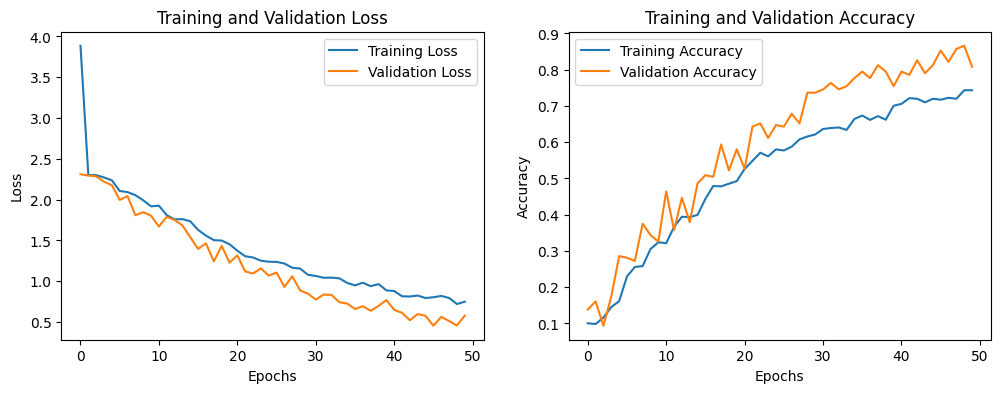

In [27]:
import matplotlib.pyplot as plt

# Access history data
history_dict = history.history

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
                 precision    recall  f1-score   support

        Battery       0.80      0.82      0.81        34
       Keyboard       0.82      0.90      0.86        20
      Microwave       0.74      0.93      0.83        28
         Mobile       0.88      0.96      0.92        23
          Mouse       0.84      0.93      0.89        29
            PCB       0.94      0.89      0.91        18
         Player       0.90      0.73      0.81        26
        Printer       0.83      0.86      0.84        22
     Television       0.96      0.61      0.75        36
Washing Machine       0.83      0.95      0.88        20

       accuracy                           0.84       256
  

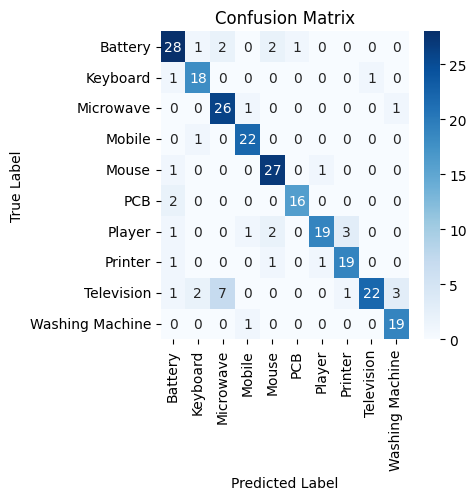

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Visualize the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [37.32698..255.0].


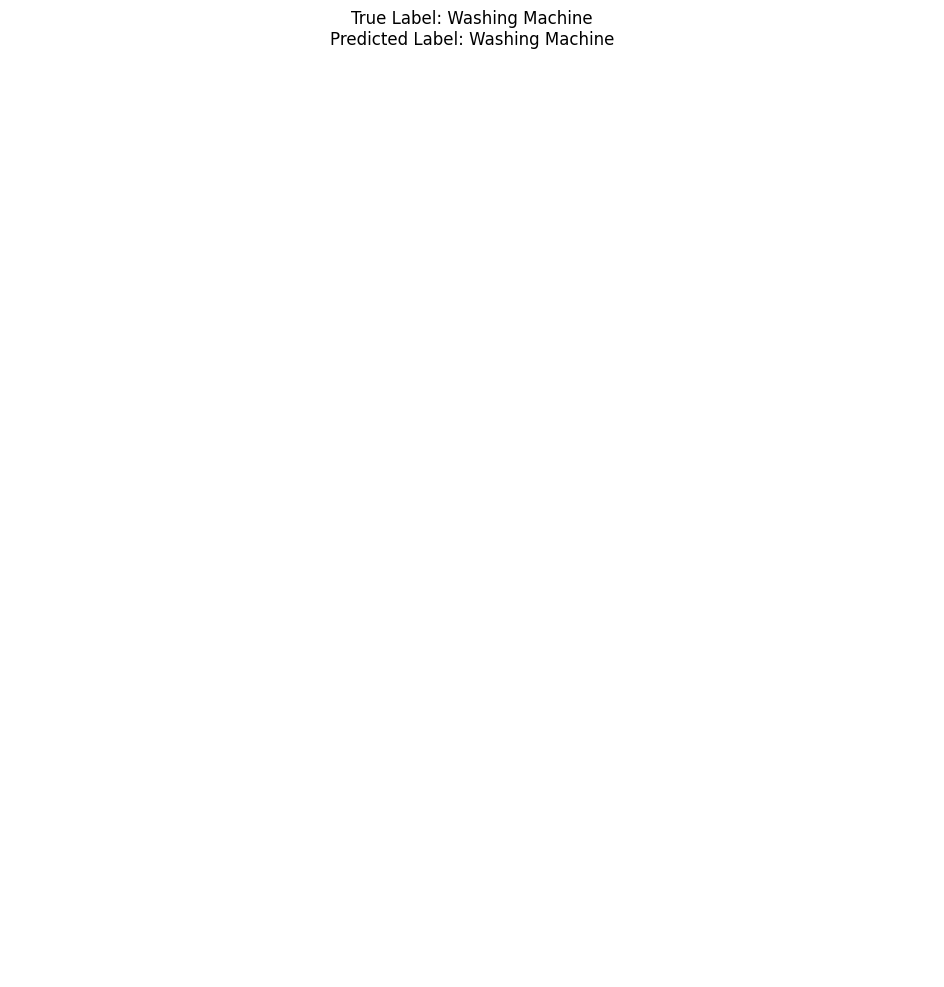

In [13]:


# Define a function to get a specific image and its label
def get_image_from_dataset(dataset, index):
    # Convert dataset to list to access specific image
    images = []
    labels = []
    for img_batch, lbl_batch in dataset:
        images.extend(img_batch.numpy())
        labels.extend(lbl_batch.numpy())
    return images[index], labels[index]

# Select an image from the test dataset (e.g., index 0 for the first image)
image, true_label = get_image_from_dataset(test_ds, 0)

# Expand dimensions to match model input shape
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Make a prediction
predictions = model.predict(image)
predicted_label = np.argmax(predictions, axis=1)[0]  # Get the predicted class index

# Convert class index to class name
class_names = dataset.class_names
true_label_name = class_names[int(true_label)]
predicted_label_name = class_names[int(predicted_label)]

# Display the image with true and predicted labels
plt.figure(figsize=(12, 12))
plt.imshow(image.squeeze())  # Remove batch dimension for display
plt.title(f'True Label: {true_label_name}\nPredicted Label: {predicted_label_name}')
plt.axis('off')
plt.show()
